# Build a conditional VAE on CIFAR-10 that can generate images of 10 classes

[Benchmark](https://paperswithcode.com/sota/image-generation-on-cifar-10)

Ref.

In [513]:
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch_directml
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy import linalg
from typing import Type
from ignite.engine import Engine, Events
from PIL import Image

## Setup device

In [514]:
for i in range(torch_directml.device_count()):
    print(i, ":", torch_directml.device_name(i))

dml = torch_directml.device(0)
print("dml =", dml)

device = dml

0 : Intel(R) UHD Graphics 730
dml = privateuseone:0


## Load data

In [515]:
training_data = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## Variables

In [516]:
# Variables
classes = training_data.classes
class_size = len(classes)
channel_num = 3
image_size = 32
train_loss_history = []

# Hyperparameters
batch_size = 32
epochs = 1
latent_size = 20
learning_rate = 0.001
weight_decay = 0
embedding_dim = 5
evaluation = False
kernel_num = 128

In [517]:
from torch.utils.data import DataLoader

training_data.data = training_data.data.astype("uint8")
test_data.data = test_data.data.astype("uint8")

kwargs = {"num_workers": 1, "pin_memory": True}

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False, **kwargs)

## Show some samples

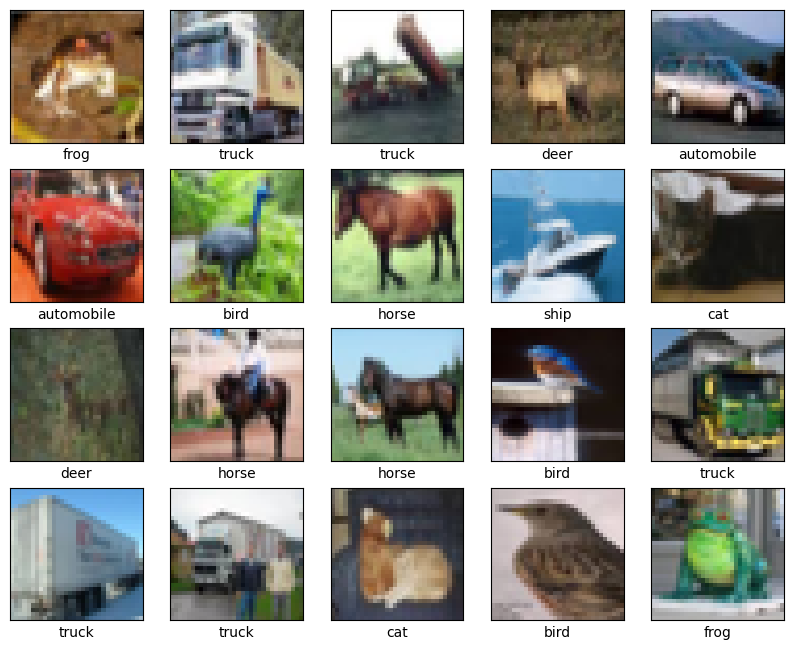

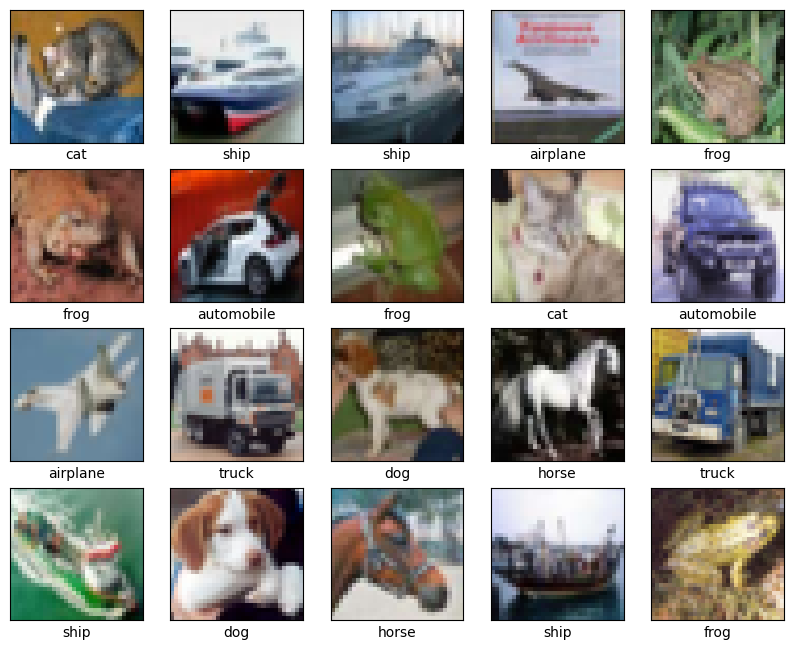

In [518]:
def show_cifar10_images(images, labels):
    plt.figure(figsize=[10, 10])

    for i in range(20):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.xlabel(classes[labels[i]])

    plt.show()


show_cifar10_images(training_data.data, training_data.targets)
show_cifar10_images(test_data.data, test_data.targets)

## Data shape

In [519]:
print("Training images shape: ", training_data.data.shape)
print("Test images shape: ", test_data.data.shape)

Training images shape:  (50000, 32, 32, 3)
Test images shape:  (10000, 32, 32, 3)


## Build cVAE model

[cVAE mechanism](https://idiotdeveloper.com/introduction-to-autoencoders/)

![cVAE mechanism](./images/variational-autoencoder.png)

Ref.

[Understanding Conditional Variational Autoencoders](https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8)

[Conditional Variational Autoencoder (cVAE) using PyTorch](https://github.com/unnir/cVAE)

[Conditional Variational Autoencoder in Keras](https://github.com/nnormandin/Conditional_VAE/blob/master/Conditional_VAE.ipynb)

[GAN Evaluation : the Frechet Inception Distance and Inception Score metrics](https://colab.research.google.com/github/pytorch-ignite/pytorch-ignite.ai/blob/gh-pages/blog/2021-08-11-GAN-evaluation-using-FID-and-IS.ipynb#scrollTo=Stp59yfH65VO)
                                                                              
[Conditional Variational Autoencoders with Learnable Conditional Embeddings](https://towardsdatascience.com/conditional-variational-autoencoders-with-learnable-conditional-embeddings-e22ee5359a2a)

### Loss function & one-hot encoding

In [520]:
def loss_function(recon_x, x, mu, logvar):
    """Reconstruction + KL divergence losses summed over all elements and batch

    See Appendix B from VAE paper:

    Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    https://arxiv.org/abs/1312.6114

    0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, image_size * image_size * channel_num), reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


def one_hot_encode(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(device)

### Model

In [521]:
from torchinfo import summary


class CVAE(nn.Module):
    """
    主要包含三個結構
    1. encoder
    2. reparameterizer
    3. decoder
    """

    def __init__(self, feature_size, latent_size, class_size, embedding_dim, *args, **kwargs) -> None:
        super(CVAE, self).__init__(*args, **kwargs)

        self.feature_size = feature_size
        self.class_size = class_size
        self.embedding_dim = embedding_dim

        self.embed_cond = nn.Embedding(num_embeddings=class_size, embedding_dim=embedding_dim, max_norm=True)

        # encoder
        # self.fc1 = nn.Linear(feature_size + class_size, 400)
        self.fc1 = self._linear(feature_size + embedding_dim, 400, True)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decoder
        # self.fc3 = nn.Linear(latent_size + class_size, 400)
        self.fc3 = self._linear(latent_size + embedding_dim, 400, True)
        self.fc4 = nn.Linear(400, feature_size)

        self.sigmoid = nn.Sigmoid()

        self.image_conv = nn.Sequential(
            self._conv(channel_num, kernel_num),
            self._conv(kernel_num, kernel_num // 2),
            self._conv(kernel_num // 2, kernel_num),
        )

        self.image_devonv = nn.Sequential(
            self._deconv(kernel_num, kernel_num // 2),
            self._deconv(kernel_num // 2, kernel_num // 4),
            self._deconv(kernel_num // 4, channel_num),
            nn.Sigmoid(),
        )

    def _conv(self, channel_size, kernel_num):
        return nn.Sequential(
            nn.Conv2d(
                channel_size,
                kernel_num,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _deconv(self, channel_num, kernel_num):
        return nn.Sequential(
            nn.ConvTranspose2d(
                channel_num,
                kernel_num,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(kernel_num),
            nn.ReLU(),
        )

    def _linear(self, in_size, out_size, relu=True):
        return (
            nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.ReLU(),
            )
            if relu
            else nn.Linear(in_size, out_size)
        )

    def encode(self, x, c):  # Q(z|x, c)
        """
        x: (bs, feature_size)
        c: (bs, class_size)
        """
        inputs = torch.cat([x, c], 1)  # (bs, feature_size + class_size)
        h1 = self.fc1(inputs)
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):  # P(x|z, c)
        """
        z: (bs, latent_size)
        c: (bs, class_size)
        """

        inputs = torch.cat([z, c], 1)  # (bs, latent_size + class_size)
        h3 = self.fc3(inputs)
        return self.sigmoid(self.fc4(h3))

    def forward(self, x, c):
        c = torch.Tensor(c).int()
        c = self.embed_cond(c)
        c = c.view(len(c), embedding_dim)

        mu, logvar = self.encode(x.view(-1, self.feature_size), c)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, c), mu, logvar

    def generate_images(self, repeat_size):
        """從隨機分布中生成指定數量的圖片"""

        with torch.no_grad():
            # 生成對稱數量的 classes (one hot)
            # c = torch.eye(gen_size, class_size).to(device)

            c = torch.Tensor(np.tile(np.arange(class_size), repeat_size)).to(device).int()

            # 隨機生成分布
            noises_z = torch.randn(repeat_size * class_size, latent_size).to(device)

            samples = self.decode(noises_z, self.embed_cond(c)).cpu()
            gen_images = samples.view(repeat_size * class_size, channel_num, image_size, image_size)

            return gen_images, c


# model = CVAE(image_size * image_size * chanel_num, latent_size, class_size, embedding_dim).to(device)
# summary_model = CVAE(image_size * image_size * chanel_num, latent_size, class_size, embedding_dim).to("cpu")

model = CVAE(image_size * image_size * channel_num, latent_size, class_size, embedding_dim).to(device)
summary_model = CVAE(image_size * image_size * channel_num, latent_size, class_size, embedding_dim).to("cpu")

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

summary(
    summary_model,
    input_size=[(batch_size, channel_num, image_size, image_size), [batch_size]],
    device="cpu",
)

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [32, 3072]                434,921
├─Embedding: 1-1                         [32, 5]                   50
├─Sequential: 1-2                        [32, 400]                 --
│    └─Linear: 2-1                       [32, 400]                 1,231,200
│    └─ReLU: 2-2                         [32, 400]                 --
├─Linear: 1-3                            [32, 20]                  8,020
├─Linear: 1-4                            [32, 20]                  8,020
├─Sequential: 1-5                        [32, 400]                 --
│    └─Linear: 2-3                       [32, 400]                 10,400
│    └─ReLU: 2-4                         [32, 400]                 --
├─Linear: 1-6                            [32, 3072]                1,231,872
├─Sigmoid: 1-7                           [32, 3072]                --
Total params: 2,924,483
Trainable params: 2,924,483
Non-

### Training

In [522]:
def train_step(epoch, data_loader: Type[DataLoader]):
    model.train()
    train_loss = 0
    loss = torch.Tensor()
    current_data_len = 0

    for batch_idx, (data, labels) in enumerate(data_loader):
        data, labels = data.to(device), labels.to(device)
        current_data_len = len(data)
        # labels = one_hot_encode(labels, class_size)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.detach().cpu().numpy()

        optimizer.step()

        # log
        if batch_idx % 20 == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    (batch_idx + 1) * len(data),
                    len(data_loader.dataset),
                    100.0 * (batch_idx + 1) / len(data_loader),
                    loss.item() / len(data),
                ),
                end="\r",
            )

            n = min(data.size(0), 5)
            comparison = torch.cat([data[:n], recon_batch.view(-1, channel_num, image_size, image_size)[:n]])
            save_image(
                comparison.cpu(),
                "./outputs/cifar-10-cvae-outputs/temp/gen/reconstruction_" + str(f"{epoch:02}") + ".png",
                nrow=n,
            )

    # Last batch of this epoch
    print(
        "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
            epoch,
            len(data_loader.dataset),
            len(data_loader.dataset),
            100,
            loss.item() / current_data_len,
        ),
        end="\r\n",
    )

    # Calculate average loss of this epoch
    train_loss /= len(data_loader.dataset)
    train_loss_history.append(train_loss)

    print("====> Epoch: {} Average loss: {:.4f}".format(epoch, train_loss))


for epoch in range(1, epochs + 1):
    train_step(epoch, train_loader)
    samples, labels = model.generate_images(1)
    save_image(
        samples,
        "./outputs/cifar-10-cvae-outputs/temp/gen/sample_" + str(f"{epoch:02}") + ".png",
    )

In [ ]:
plt.figure(figsize=[6, 4])
plt.plot(train_loss_history, "green", linewidth=2.0)
plt.legend(["Training Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)
plt.show()

In [ ]:
repeat_size = 1000
gen_images, gen_labels = model.generate_images(repeat_size)

save_image(
    gen_images[:10],
    "./outputs/cifar-10-cvae-outputs/temp/gen/evaluation.png",
)

pil_img = []

for img in gen_images:
    pil_img.append(transforms.ToPILImage()(img))

show_cifar10_images(pil_img, gen_labels)

## FID evaluation

Ref.

Inception v3 architecture

![Inception v3 architecture](./images/inception_v3.png)

[GAN in Pytorch with FID](https://www.kaggle.com/code/ibtesama/gan-in-pytorch-with-fid#References)

In [ ]:
from torcheval.metrics.image import FrechetInceptionDistance


def interpolate(images):
    """
    Inception v3 model 需要輸入為 299 * 299 * 3
    所以需要先將 32 * 32 * 3 的 cifar-10 資料重新調整大小
    """
    stack = []

    for img in images:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        stack.append(transforms.ToTensor()(resized_img))

    return torch.stack(stack)


fid_metric = FrechetInceptionDistance().to("cpu")


def fid_evaluation(real, gen):

    gen = interpolate(gen)
    real = interpolate(real)

    fid_metric.update(real, is_real=True)
    fid_metric.update(gen, is_real=False)
    fid = fid_metric.compute()
    fid_metric.reset()

    return fid


if evaluation:
    fids = []

    for batch_idx, (data, labels) in enumerate(test_loader):

        fid = fid_evaluation(data, gen_images[batch_idx * 1000 : (batch_idx * 1000) + 1000])
        fids.append(fid)

        print(
            "FID Evaluation: [{}/{} ({:.0f}%)]\tFID: {:.6f}".format(
                (batch_idx + 1) * len(data), len(test_loader.dataset), 100.0 * (batch_idx + 1) / len(test_loader), fid
            ),
            end="\r",
        )

    print("\nAverage FID:", np.mean(fids))